In [1]:
%load_ext autoreload

import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../m2py/networks/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as PhysLoss
import network_utils as nuts

torch.manual_seed(28)

# This notebook seeks to use all OPV processing conditions and morphological descriptors to predict device performance. 

## There will be 3 Neural Networks outlined, each with similar architecture, but varying inputs. This second NN will incorporate morphological information. However, morphological descriptors will be averaged per sample, similar to how device metrics are an average of performance across the active layer

### Inputs:
- DataFrame containing device processing conditions and their subsequent performance. This will similarly only include good devices

- DataFrame containing device-averaged morphology descriptors

### Outputs:
- Tensor of predicted performance for given processing conditions

In [2]:
#Take in data as a dataframe for easy preprocessing
total_df = pd.read_excel('/Users/wesleytatum/Desktop/OPV_total_df.xlsx')
print (total_df.shape)
total_df.head()

(108, 20)


,Unnamed: 0,Anneal_time,Anneal_temp,Substrate,Device,MajorAL_avg,MajorAL_stdev,MinorAL_avg,MinorAL_stdev,Ecc_avg,Ecc_stdev,Orient_avg,Orient_stdev,Perim_avg,Perim_stdev,GMM_label,PCE,VocL,Jsc,FF
0,0,15,100,4,2,17.194652,29.172066,8.554721,14.246681,0.820518,0.142370,-0.050137,1.067225,97.003245,352.677591,1,2.311387,0.577792,6.963861,57.44484
1,1,15,100,4,4,13.709728,14.635628,6.938374,7.985216,0.824877,0.138410,-0.205623,1.075388,48.559552,98.492589,1,1.763230,0.522596,7.047848,47.87256
2,2,15,100,4,7,18.211098,21.013541,8.857453,10.356933,0.826205,0.148190,-0.414390,1.047842,75.736366,151.456627,1,2.394418,0.575790,6.939877,59.92170
3,3,30,100,7,2,19.640309,46.935628,9.781374,26.994708,0.857443,0.105577,-0.331902,0.940640,236.482362,1306.085256,1,2.628197,0.569525,7.301575,63.20169
4,4,30,100,7,4,20.647291,35.791550,8.412561,11.216702,0.833485,0.136928,-0.454930,0.862964,96.093361,315.148913,1,2.710602,0.568631,7.328048,65.04993


In [3]:
# Hyper parameters
num_epochs = 50
batch_size = int(len(total_df['PCE'])*0.8*0.9) # 90% of x_train samples
learning_rate = 0.002

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
X = total_df[['Anneal_time', 'Anneal_temp', 'MajorAL_avg', 'MajorAL_stdev', 'MinorAL_avg',
              'MinorAL_stdev', 'Ecc_avg', 'Ecc_stdev', 'Orient_avg', 'Orient_stdev', 'Perim_avg',
              'Perim_stdev', 'GMM_label']] #input features used to make prediction
Y = total_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

In [5]:
x_train, x_train_key = nuts.df_normalizer(x_train)
y_train, y_train_key = nuts.df_normalizer(y_train)

x_test, x_test_key = nuts.df_normalizer(x_test)
y_test, y_test_key = nuts.df_normalizer(y_test)


pce_train = y_train['PCE']
pce_test = y_test['PCE']
voc_train = y_train['VocL']
voc_test = y_test['VocL']
jsc_train = y_train['Jsc']
jsc_test = y_test['Jsc']
ff_train = y_train['FF']
ff_test = y_test['FF']

In [6]:
x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
pce_train_tensor = torch.tensor(pce_train.values.astype(np.float32))
voc_train_tensor = torch.tensor(voc_train.values.astype(np.float32))
jsc_train_tensor = torch.tensor(jsc_train.values.astype(np.float32))
ff_train_tensor = torch.tensor(ff_train.values.astype(np.float32))

#create tensor with features and targets
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, pce_train_tensor, voc_train_tensor, jsc_train_tensor, ff_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = False)

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
pce_test_tensor = torch.tensor(pce_test.values.astype(np.float32))
voc_test_tensor = torch.tensor(voc_test.values.astype(np.float32))
jsc_test_tensor = torch.tensor(jsc_test.values.astype(np.float32))
ff_test_tensor = torch.tensor(ff_test.values.astype(np.float32))

test_tensor = torch.utils.data.TensorDataset(x_test_tensor, pce_test_tensor, voc_test_tensor, jsc_test_tensor, ff_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = False)

Now that the data, model, training, and evaluating are all set up, let's actually use everything

In [7]:
# takes in 8 features (anneal time, anneal temp, MajorAL, MinorAL, Ecc, Orient, Perim, GMM_label) 
# predicts 4 metrics (PCE, Voc, Jsc, FF)
in_dims = int(x_train_tensor.size(1)) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)

#define the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [8]:
%autoreload

#empty list to hold loss per epoch
train_epoch_losses = []
pce_train_epoch_losses = []
voc_train_epoch_losses = []
jsc_train_epoch_losses = []
ff_train_epoch_losses = []

test_epoch_losses = []
pce_test_epoch_losses = []
voc_test_epoch_losses = []
jsc_test_epoch_losses = []
ff_test_epoch_losses = []

pce_test_epoch_accuracies = []
voc_test_epoch_accuracies = []
jsc_test_epoch_accuracies = []
ff_test_epoch_accuracies = []

for epoch in range(num_epochs):
    
    train_loss, pce_train_loss, voc_train_loss, jsc_train_loss, ff_train_loss = train.train_OPV_df_model(model = model,
                                                                                                         training_data_set = training_data_set,
                                                                                                         optimizer = optimizer)
    train_epoch_losses.append(train_loss)
    pce_train_epoch_losses.append(pce_train_loss)
    voc_train_epoch_losses.append(voc_train_loss)
    jsc_train_epoch_losses.append(jsc_train_loss)
    ff_train_epoch_losses.append(ff_train_loss)
    
    test_loss, pce_test_loss, voc_test_loss, jsc_test_loss, ff_test_loss, pce_acc, voc_acc, jsc_acc, ff_acc = test.eval_OPV_df_model(model = model,
                                                                                                                                    testing_data_set = testing_data_set)
    test_epoch_losses.append(test_loss)
    pce_test_epoch_losses.append(pce_test_loss)
    voc_test_epoch_losses.append(voc_test_loss)
    jsc_test_epoch_losses.append(jsc_test_loss)
    ff_test_epoch_losses.append(ff_test_loss)
    
    pce_test_epoch_accuracies.append(pce_acc)
    voc_test_epoch_accuracies.append(voc_acc)
    jsc_test_epoch_accuracies.append(jsc_acc)
    ff_test_epoch_accuracies.append(ff_acc)

Total Epoch Testing Loss = 0.10749495029449463
Total Epoch Testing Accuracy: PCE = 58.51413329893892
                              Voc = 127.72475860335611
                              Jsc = 56.30152745341713
                              FF = 87.15803135525097
Total Epoch Testing Loss = 0.09418033808469772
Total Epoch Testing Accuracy: PCE = 54.89797409285199
                              Voc = 118.60415068539707
                              Jsc = 51.8310396508737
                              FF = 74.9558757651936
Total Epoch Testing Loss = 0.08450362831354141
Total Epoch Testing Accuracy: PCE = 51.23778844082897
                              Voc = 109.24168093637986
                              Jsc = 47.106804427775465
                              FF = 61.85237507928502
Total Epoch Testing Loss = 0.07903540879487991
Total Epoch Testing Accuracy: PCE = 49.25698202780702
                              Voc = 99.33607117696242
                              Jsc = 41.88559180633588
   

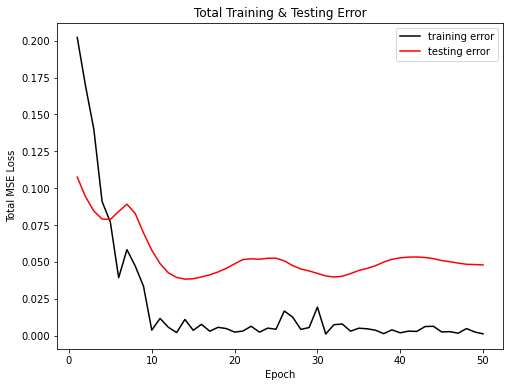

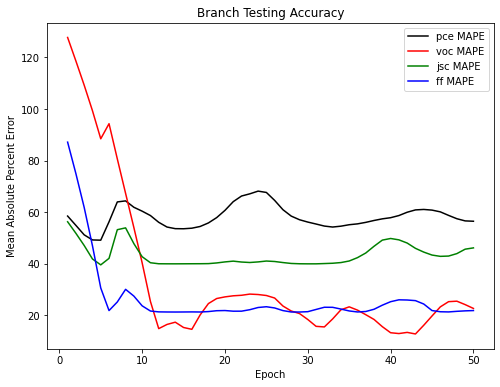

In [9]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total MSE Loss')
plt.show()

fig, ax = plt.subplots(figsize = (8,6))
# plt.plot(epochs, train_epoch_accuracy, c = 'k', label = 'training accuracy')
plt.plot(epochs, pce_test_epoch_accuracies, c = 'k', label = 'pce MAPE')
plt.plot(epochs, voc_test_epoch_accuracies, c = 'r', label = 'voc MAPE')
plt.plot(epochs, jsc_test_epoch_accuracies, c = 'g', label = 'jsc MAPE')
plt.plot(epochs, ff_test_epoch_accuracies, c = 'b', label = 'ff MAPE')
plt.legend(loc = 'upper right')
plt.title("Branch Testing Accuracy")
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Percent Error')
plt.show()

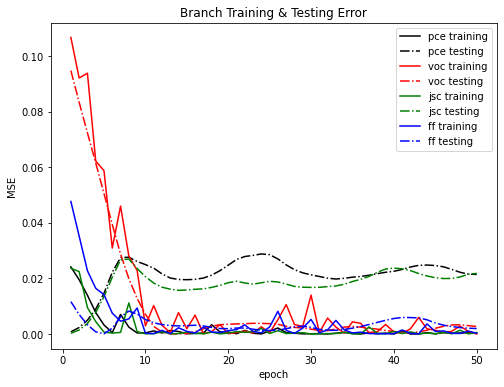

In [10]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, pce_train_epoch_losses, c = 'k', label = 'pce training')
plt.plot(epochs, pce_test_epoch_losses, '-.', c = 'k', label = 'pce testing')

plt.plot(epochs, voc_train_epoch_losses, c = 'r', label = 'voc training')
plt.plot(epochs, voc_test_epoch_losses, '-.', c = 'r', label = 'voc testing')

plt.plot(epochs, jsc_train_epoch_losses, c = 'g', label = 'jsc training')
plt.plot(epochs, jsc_test_epoch_losses, '-.', c = 'g', label = 'jsc testing') #This error is second worst

plt.plot(epochs, ff_train_epoch_losses, c = 'b', label = 'ff training') 
plt.plot(epochs, ff_test_epoch_losses, '-.', c = 'b', label = 'ff testing') #This error is by far the worst

plt.legend(loc = 'upper right')
plt.title("Branch Training & Testing Error")
ax.set_xlabel('epoch')
ax.set_ylabel('MSE')
plt.show()

In [11]:
model.eval()

with torch.no_grad():
    for inputs, pce_labels, voc_labels, jsc_labels, ff_labels in testing_data_set:
        inputs = inputs.to(device)
        pce_labels = pce_labels.to(device)
        voc_labels = voc_labels.to(device)
        jsc_labels = jsc_labels.to(device)
        ff_labels = ff_labels.to(device)

        PCE_out, Voc_out, Jsc_out, FF_out = model(inputs)


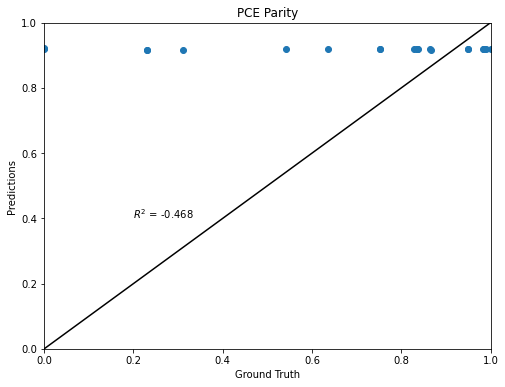

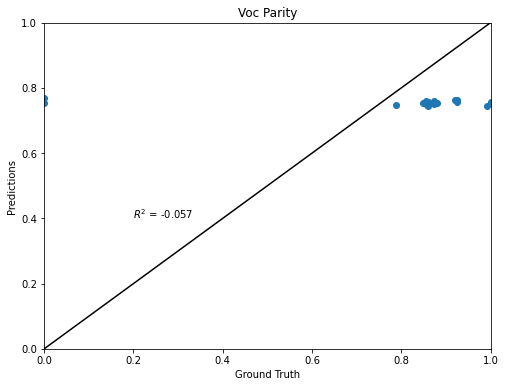

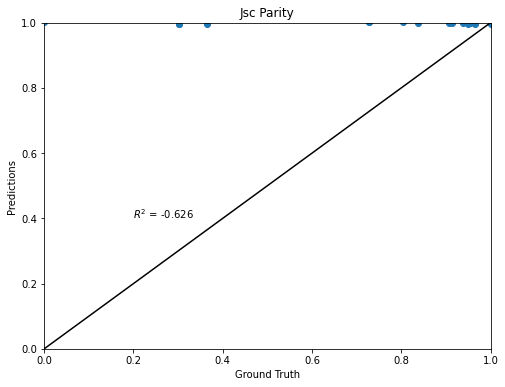

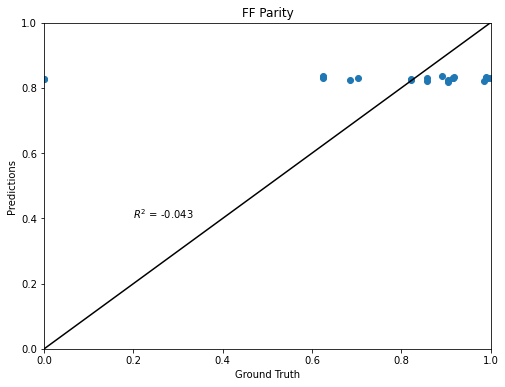

In [12]:
xlin = ylin = np.arange(0, 100, 1)

r2 = r2_score(pce_labels, PCE_out)
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(pce_labels, PCE_out)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('PCE Parity')
plt.show()

r2 = r2_score(voc_labels, Voc_out)
fig, ax = plt.subplots(figsize = (8,6))
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4))
plt.scatter(voc_labels, Voc_out)
plt.plot(xlin, ylin, c = 'k')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Voc Parity')
plt.show()

r2 = r2_score(jsc_labels, Jsc_out)
fig, ax = plt.subplots(figsize = (8,6))
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4))
plt.scatter(jsc_labels, Jsc_out)
plt.plot(xlin, ylin, c = 'k')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Jsc Parity')
plt.show()

r2 = r2_score(ff_labels, FF_out)
fig, ax = plt.subplots(figsize = (8,6))
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4))
plt.scatter(ff_labels, FF_out)
plt.plot(xlin, ylin, c = 'k')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('FF Parity')
plt.show()